# Regularization, Over/Underfitting, and the Bias-Variance Tradeoff

In the MNIST lab we went through a simple supervised learning experiment:

    1. start with some labeled data
    2. do exploratory data analysis
    3. split into train and test sets
    4. train a classifier on the training set
    5. evaluate the classifier on the test set
    
Today we're going to run through a similar workflow but with an extra step: adjusting hyperparameters of the model to see how they affect the model's performance.

The model we're going to use is **logistic regression** with **ridge** (or $L_{2}$-norm) regularization. This is just a boring linear model plus an extra term that adds a cost to increasing the size of the model's weights. There's a single hyperparameter that controls the cost.

If the cost is high it **biases** the model toward smaller weights- essentially making the model less flexible, but at the same time less prone to overfitting (finding spurious correlations in our data). Overfitting is a particularly big concern if we have a small number of samples and/or a large number of columns.

If the cost is low our model has **lower bias**, meaning that it's more flexible. This will let it find more subtle patterns in the training data, but also means that there are more combinations of weights that all fit the data about as well as each other- so estimates of those weights will have a **higher variance**.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sklearn.linear_model, sklearn.preprocessing, sklearn.metrics

%matplotlib inline
from IPython.core.pylabtools import figsize

## Load and prep the data

Today we're using the Titanic dataset. We have a bunch of information about every passenger aboard the Titanic, and want to build a classifier to predict who lives, who dies, and who gets drawn like one of your french girls. The columns of the CSV file are:

* **survived:** this is what we're trying to predict; 1 if the passenger survived and 0 if they didn't
* **pclass:** passenger class (1st, 2nd, 3rd)
* **sex:** gender of the passenger
* **age:** passenger's age in years
* **sibsp:** number of siblings and spouses traveling with the passenger
* **parch:** number of parents and children traveling with the passenger
* **fare:** how much the passenger's ticket cost
* **embarked:** where the passenger embarked from; (C)herbourg, (Q)ueenstown, or (S)outhampton

There are also some columns we won't use: **name**, **ticket**, **boat**, **body**, **cabin**, and **home destination**. If you're feeling clever feel free to extract more columns from those (like what deck the passenger's cabin is on or whether they're married).

I'll provide the code here that I used to prepare some features- doing EDA is up to you. If you want to explore, try out things like

* `data["sex"].value_counts()` count the number of times each value of the "sex" column occurs
* `pd.crosstab(data["pclass"], data["survived"])` count the number of times each combination of "pclass" and "survived" occur.
* `plt.hist(data.fare)` draw  a histogram of fares

First, read the data:

In [2]:
data = pd.read_csv("/media/joe/HD/data/titanic.csv")
len(data)

1309

In [3]:
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


Drop the columns we're not going to use:

In [4]:
data = data.drop(["boat", "body", "home.dest", "cabin", "name"], axis=1)

Drop rows with missing data:

In [5]:
data = data.dropna()
len(data)

1043

Build an indicator variable for the passenger's gender- we want to map `female` to 0 and `male` to 1:

In [10]:
data["gender"] = data["sex"].map({"female":0, "male":1}).astype(int)

Build three dummy variables for the three different embarkments:

In [11]:
embark_dummies = pd.get_dummies(data['embarked'], prefix='embarked')
embark_dummies.head()

,embarked_C,embarked_Q,embarked_S
0,0,0,1
1,0,0,1
2,0,0,1
3,0,0,1
4,0,0,1


In [12]:
data = pd.concat([data, embark_dummies], axis=1)

Now let's pull out a dataframe of just the columns we'll use as features for machine learning:

In [14]:
X = data[["pclass", "age", "sibsp", "parch", "fare", "gender", "embarked_C", "embarked_Q", "embarked_S"]]
X.head()

,pclass,age,sibsp,parch,fare,gender,embarked_C,embarked_Q,embarked_S
0,1,29.0000,0,0,211.3375,0,0,0,1
1,1,0.9167,1,2,151.5500,1,0,0,1
2,1,2.0000,1,2,151.5500,0,0,0,1
3,1,30.0000,1,2,151.5500,1,0,0,1
4,1,25.0000,1,2,151.5500,0,0,0,1


And the corresponding labels:

In [15]:
Y = data.survived

And split both into 70/30 training/testing sets:

In [16]:
np.random.seed(1)
split = np.random.choice([True, False], p=[0.7, 0.3], size=len(data))

In [17]:
X_train = X[split]
X_test = X[~split]

Y_train = Y[split]
Y_test = Y[~split]

In [18]:
X_train.head()

,pclass,age,sibsp,parch,fare,gender,embarked_C,embarked_Q,embarked_S
0,1,29.0,0,0,211.3375,0,0,0,1
2,1,2.0,1,2,151.5500,0,0,0,1
3,1,30.0,1,2,151.5500,1,0,0,1
4,1,25.0,1,2,151.5500,0,0,0,1
5,1,48.0,0,0,26.5500,1,0,0,1


## train a model

Since this is a generic machine learning problem let's save some time and use a generic machine learning library, `sklearn`.

All the models in `sklearn` have the same basic interface:

* Define a model with something like `model = sklearn.submodule.ModelType(model parameters)`
* Train with `model.fit(training_data, training_labels)`
* Predict on new data with `model.predict(test_data, test_labels)`

For regularized logistic regression, there's also a necessary preprocessing step- to make sure our cost effects all the columns equally, we need to make sure that all the columns are roughly the same size. A standard approach is, for each column, to subtract the mean and then divide by the standard deviation. This makes sure that every column has mean 0 and standard deviation 1. 

The `sklearn.preprocessing.StandardScaler()` object automates this for us. Note that, like always, we do any preprocessing **only on the training set**.

Finally, notice that the regularization constant `C` is the *inverse* regularization strength (so a smaller value means larger cost). I realize that they're trying to make it similar to their support vector machine interface but I still think it's a boorish API decision. 

In [19]:
scaler = sklearn.preprocessing.StandardScaler().fit(X_train)
model = sklearn.linear_model.LogisticRegression(penalty="l2", C=1.)
model = model.fit(scaler.transform(X_train), Y_train)

In [20]:
train_predictions = model.predict(scaler.transform(X_train))
test_predictions = model.predict(scaler.transform(X_test))

In [21]:
train_accuracy = sklearn.metrics.accuracy_score(Y_train, train_predictions)
test_accuracy = sklearn.metrics.accuracy_score(Y_test, test_predictions)

print("train accuracy: %s"%train_accuracy)
print("test accuracy: %s"%test_accuracy)

train accuracy: 0.805442176871
test accuracy: 0.756493506494


As expected, the model does better on the training set than the test set.

## Hyperparameter tuning

Now let's try varying the regularization strength `C` and see how it changes the model's performance.

To simplify the rest of the notebook, we'll write a little function that automates the above: it inputs a value for the regularization (and optionally a training set and labels), and it trains a model and returns the training and test set accuracies:

In [22]:
def training_experiment(C, train=X_train, labels=Y_train):
    scaler = sklearn.preprocessing.StandardScaler().fit(train)
    model = sklearn.linear_model.LogisticRegression(penalty="l2", C=C)
    model = model.fit(scaler.transform(train), labels)
    
    train_predictions = model.predict(scaler.transform(train))
    test_predictions = model.predict(scaler.transform(X_test))
    
    train_accuracy = sklearn.metrics.accuracy_score(labels, train_predictions)
    test_accuracy = sklearn.metrics.accuracy_score(Y_test, test_predictions)
    
    return train_accuracy, test_accuracy

Let's pick a big range (on a logarithmic scale) of regularization strengths to sweep over:

In [23]:
# inverse regularization strength: smaller values =  more regularization
Cvals = 10**np.linspace(-20, 2, 50)

For those of you who aren't big Python fans, the following line is called a **list comprehension.** It will generate a list of results of `training_experiment`, one for each value of the regularization strength in `Cvals`.

In [24]:
accuracies = [training_experiment(c) for c in Cvals]

Now plot training and test accuracy as a function of regularization:

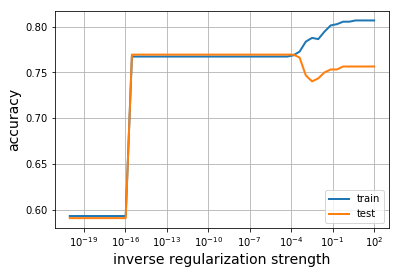

In [25]:
plt.plot(Cvals, [a[0] for a in accuracies], "-", label="train", lw=2)
plt.plot(Cvals, [a[1] for a in accuracies], "-", label="test", lw=2)
plt.legend(loc="lower right")
plt.grid("on")
plt.xlabel("inverse regularization strength", fontsize=14)
plt.ylabel("accuracy", fontsize=14)
plt.xscale("log");

Some notes on interpreting this:

* If the regularization cost is too high (left-hand side), it basically turns all the parameters "off". Don't do this.
* There's a big range in the middle where the test and train accuracies are about the same. You could probably pick any value in this range and it wouldn't matter much, but a common practice is to take the largest strength (smallest C) that's within one standard error of the optimal value (the "1se rule").
* If the regularization cost is too low (right-hand side) the model **overfits:** the training accuracy increases as the model memorizes noise, and the test accuracy drops off.

## Visualizing the bias-variance tradeoff

When we go through the BVT derivation, we see that one part of a model's error comes from the variance in estimating its parameters. If we have less data, we'd expect that variance to get larger.

Let's take a tiny random sample of our training set and try repeating our above hyperparameter sweep. Notice that we'll **keep the test set the same** to make sure we're doing an apples-to-apples comparison.

In [28]:
np.random.seed(2)
tiny_sample = np.random.choice(range(len(Y_train)), replace=False, size=15)
X_tiny = X_train.iloc[tiny_sample]
Y_tiny = Y_train.iloc[tiny_sample]

In [29]:
accuracies_tiny = [training_experiment(c, X_tiny, Y_tiny) for c in Cvals]

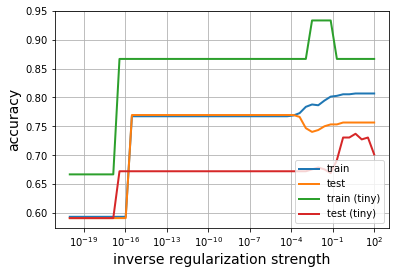

In [30]:
plt.plot(Cvals, [a[0] for a in accuracies], "-", label="train", lw=2)
plt.plot(Cvals, [a[1] for a in accuracies], "-", label="test", lw=2)
plt.plot(Cvals, [a[0] for a in accuracies_tiny], "-", label="train (tiny)", lw=2)
plt.plot(Cvals, [a[1] for a in accuracies_tiny], "-", label="test (tiny)", lw=2)

plt.xlabel("inverse regularization strength", fontsize=14)
plt.ylabel("accuracy", fontsize=14)
plt.legend(loc="lower right")
plt.grid("on")
plt.xscale("log");

Some notes:

* The training accuracy looks great, doesn't it? The model has 10 free parameters, so it's not surprising that it can find a pretty good separation between 15 training points. This is why we never, ever report performance measures on the training set.
* Notice that not only is the test accuracy significantly lower for the model trained on a smaller training set, but it picks a completely different optimal range for the hyperparameter.

If we built a bunch of 15-point training sets, would they all look like this? Let's make a bunch of tiny datasets and repeat the same hyperparameter sweep for each to see how much variation there is in the test accuracy:

In [32]:
N = 100
reg_curves = np.zeros((N, len(Cvals)))

for i in range(N):
    tiny_sample = np.random.choice(range(len(Y_train)), replace=False, size=15)
    X_tiny = X_train.iloc[tiny_sample]
    Y_tiny = Y_train.iloc[tiny_sample]
    accuracies_tiny = [training_experiment(c, X_tiny, Y_tiny) for c in Cvals]
    reg_curves[i,:] = np.array([a[1] for a in accuracies_tiny])

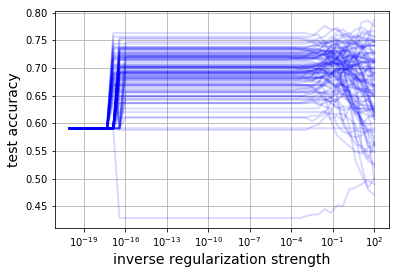

In [33]:
for i in range(N):
    plt.plot(Cvals, reg_curves[i,:], "b-", label="test (tiny)", lw=2, alpha=0.15)
    
plt.xlabel("inverse regularization strength", fontsize=14)
plt.ylabel("test accuracy", fontsize=14)
plt.grid("on")
plt.xscale("log");

The lines in the above plot are all over the place, but they're not *uniformly* all over the place. For each value of `C`, let's compute the variance in test accuracies to see how much the model performance varies as we change the regularization:

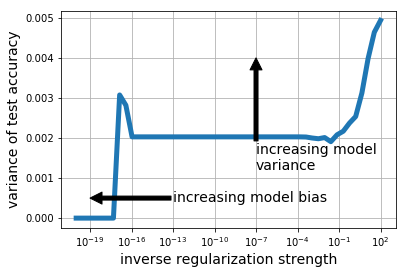

In [58]:
plt.plot(Cvals, reg_curves.var(axis=0), lw=5)

plt.annotate("increasing model bias", xy=(1e-19,0.5e-3), 
             xytext=(1e-13,0.5e-3),
            arrowprops=dict(facecolor="black"), 
             verticalalignment="center",
            fontsize=14)

plt.annotate("increasing model\nvariance", xy=(1e-7,4e-3), 
             xytext=(1e-7,1.5e-3),
            arrowprops=dict(facecolor="black"), 
             verticalalignment="center",
            fontsize=14)

plt.grid("on")
plt.ylabel("variance of test accuracy", fontsize=14)
plt.xlabel("inverse regularization strength", fontsize=14)
plt.xscale("log");

This is the **bias-variance tradeoff.** As we move to the right on the graph (decreasing the cost of a more complex model), we're reducing bias by making it more flexible. The bad news is that the variation in how the model performs tends to increase in the direction, so we need more data to fit the model reliably.